In [2]:
import sys
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
# from load_dataset import load
# from classifier import NeuralNetwork, LogisticRegression, SVM
# from utils import *
# from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
# torch.manual_seed(1)

**Deviations**

In [99]:
# '''LR'''
# percent_ranges = [20, 20, 5]
# deviation_spd = ([0.007725877471437485, 0.004820336013760169, 0.011056731092158044],
#  [0.003009496194581448, 0.0038871918275750596, 0.006107804227256791],
#  [0.006368134000028169, 0.01126190795250957, 0.017219688421623306])
# deviation_tpr_parity = ([0.007244478023795466, 0.0028992891192249183, 0.011602528640809372],
#  [0.0026471682345426614, 0.0019717447799022917, 0.007347070407187301],
#  [0.002877509405135828, 0.006767894229127711, 0.015043907126394689])
# deviation_predictive_parity = ([0.0031647908909096926, 0.0010533952648038264, 0.005726507722465053],
#  [0.00295839819502512, 0.001032370372990089, 0.003943106729214387],
#  [0.0062166500654808644, 0.0029177590845621206, 0.002224683414506734])

In [104]:
'''SVM'''
percent_ranges = [20, 20, 10]
deviation_spd = ([0.005605144729476311, 0.0025189044507238066, 0.01689279699700631],
 [0.0009998697974949737, 0.0011257525069833583, 0.007940990696436093],
 [0.005826167861232537, 0.004103361823792109, 0.007943593559321052])
deviation_tpr_parity = ([0.00550037533573914, 0.001982356024870507, 0.01396743177944115],
 [0.0008598238972720194, 0.0010966953874543277, 0.007200848385663984],
 [0.005705159083108434, 0.0036199609838345266, 0.007906578141727972])
deviation_predictive_parity = ([0.006848818507657065, 0.0012223568098598371, 0.005983732473545773],
 [0.0030877123563960757, 0.0006001605161700533, 0.0029326285126193893],
 [0.004098982014017816, 0.0011538971458175725, 0.003316035451975452])

In [105]:
# '''NN'''
# percent_ranges = [20, 20, 5]
# deviation_spd = ([0.018900017022169948, 0.005802756213259168, 0.013918195076467096],
#  [0.016141579081506704, 0.005557453177485212, 0.004685280969946213],
#  [0.0132840083615685, 0.008455786445281572, 0.023016876835996902])
# deviation_tpr_parity = ([0.01436826571068522, 0.004252539802488902, 0.013678716510545124],
#  [0.012671703927120009, 0.004019229821603904, 0.005546095633181103],
#  [0.009850473363338944, 0.007645462104989406, 0.018747592620431977])
# deviation_predictive_parity = ([0.00500539998207015, 0.001749393229522876, 0.007384954730689158],
#  [0.004798391900958645, 0.0016722648755844256, 0.00694842016643617],
#  [0.007246170872525955, 0.0016912461382703246, 0.005764243005220671])

In [106]:
deviation_first = []
deviation_first += deviation_spd[0]
# deviation_first +=  [0]
deviation_first += deviation_tpr_parity[0]
# deviation_first +=  [0]
deviation_first += deviation_predictive_parity[0]

deviation_second = []
deviation_second += deviation_spd[1]
# deviation_second +=  [0]
deviation_second += deviation_tpr_parity[1]
# deviation_second +=  [0]
deviation_second += deviation_predictive_parity[1]

deviation_gd = []
deviation_gd += deviation_spd[2]
# deviation_gd +=  [0]
deviation_gd += deviation_tpr_parity[2]
# deviation_gd +=  [0]
deviation_gd += deviation_predictive_parity[2]

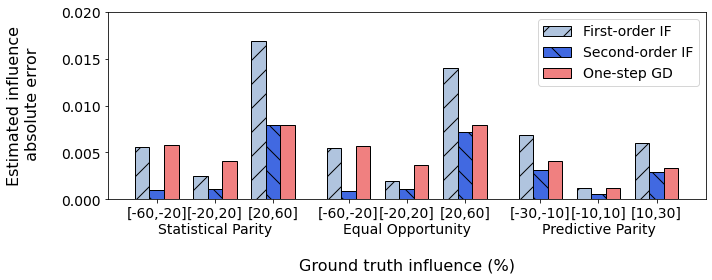

In [107]:
plt.figure(figsize=(10,4))
width = 0.25
alpha = 0.6
bin_num = 3
empty_width = 0.3

edge_color = np.zeros((bin_num, 4))
edge_color[:, 3] = 1.0 # alpha
edge_width = 1

bar_color_first = np.zeros((bin_num, 4))
bar_color_first[:, 2] = 1.0 # blue
bar_color_first[:, 3] = 0.2 # alpha

bar_color_second = np.zeros((bin_num, 4))
bar_color_second[:, 2] = 1.0 # blue
bar_color_second[:, 3] = 0.7 # alpha

bar_color_gd = np.zeros((bin_num, 4))
bar_color_gd[:, :1] = 1.0 # :3 yellow
bar_color_gd[:, 3] = 0.5 # alpha

index = np.arange(bin_num*3).astype(float)
index[3:6] += empty_width
index[6:9] += 2*empty_width
plt.bar(index-width, deviation_first, width, label='First-order IF', color='lightsteelblue',\
        linewidth=edge_width, edgecolor=edge_color, hatch='/')
plt.bar(index, deviation_second, width, label='Second-order IF', color='royalblue',\
       linewidth=edge_width, edgecolor=edge_color, hatch='\\')
plt.bar(index+width, deviation_gd, width, label='One-step GD', color='lightcoral',\
       linewidth=edge_width, edgecolor=edge_color)
ticks_1 = [f'[{(2*bin_id-3)*percent_ranges[0]},{(2*bin_id-1)*percent_ranges[0]}]' for bin_id in range(bin_num)]
ticks_1[1] += '\nStatistical Parity'
ticks_2 = [f'[{(2*bin_id-3)*percent_ranges[1]},{(2*bin_id-1)*percent_ranges[1]}]' for bin_id in range(bin_num)]
ticks_2[1] += '\nEqual Opportunity'
ticks_3 = [f'[{(2*bin_id-3)*percent_ranges[2]},{(2*bin_id-1)*percent_ranges[2]}]' for bin_id in range(bin_num)]
ticks_3[1] += '\nPredictive Parity'
# print(ticks_1)
# print(ticks_2)
# print(ticks_3)
plt.xticks(index, ticks_1 + ticks_2 + ticks_3, rotation=0, fontsize=14)
plt.yticks(np.arange(0, 0.025, 0.005), fontsize=14)
# plt.grid()
plt.ylabel('Estimated influence\n absolute error\n', fontsize=16)
# , fontweight='bold')
plt.xlabel('\nGround truth influence (%)',\
           fontsize=16)
#            , fontweight='bold')
# plt.legend(fontsize=12, prop={'weight':'bold'})
plt.legend(fontsize=14)
plt.tight_layout()
# plt.show()
plt.savefig('updated_effectiveness-svm.pdf', dpi=150)

**Time**

In [112]:
# NN/SVM/LR
clf_name = 'SVM'
pers = np.load(f'{clf_name}_pers.npy')
pers_avg = np.mean(pers, axis=2).squeeze()
first_xs = second_xs = gt_xs = gd_xs = np.arange(1, 26)*2

first_ys = pers_avg[:, 0]
second_ys = pers_avg[:, 1]
gt_ys = pers_avg[:, 2]
gd_ys = pers_avg[:, 3]

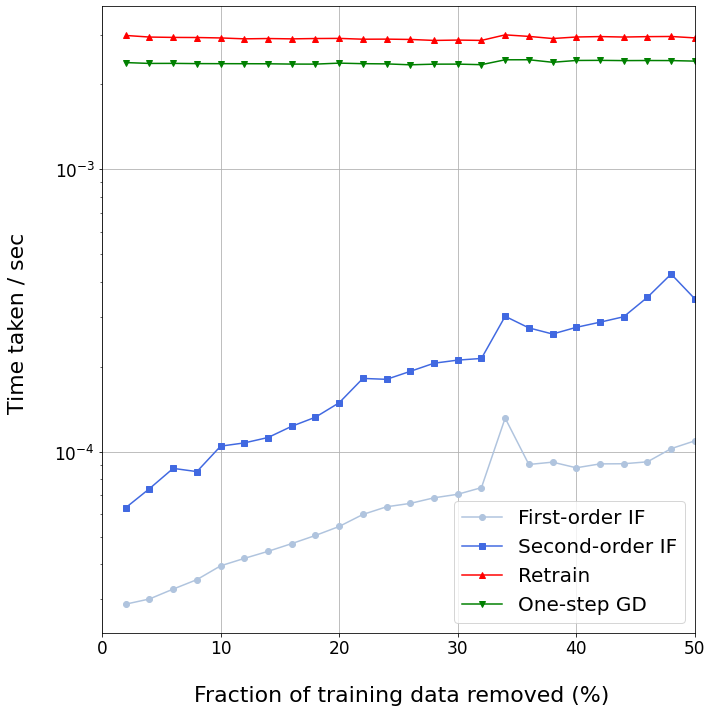

In [113]:
plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.plot(first_xs, first_ys, '-', c='lightsteelblue', label='First-order IF', marker="o")
plt.plot(second_xs, second_ys, '-', c='royalblue', label='Second-order IF', marker="s")
plt.plot(gt_xs, gt_ys, '-', c='red', label='Retrain', marker="^")
plt.plot(gd_xs, gd_ys, '-', c='green', label='One-step GD', marker="v")

plt.legend(loc='lower right', fontsize=20)
plt.grid()
plt.xlabel('\n Fraction of training data removed (%)', fontsize=22)
plt.ylabel('Time taken / sec \n', fontsize=22)
plt.yscale("log")
plt.xlim(0, 50)
plt.tight_layout()
# plt.show()
plt.savefig(f'time-{clf_name}.pdf', dpi=150)